In [1]:
# api key
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
import os

# 디버깅을 위한 프로젝트명을 기입합니다.
os.environ["LANGCHAIN_PROJECT"] = "RAG Base"

# tracing 을 위해서는 아래 코드의 주석을 해제하고 실행합니다.
# os.environ["LANGCHAIN_TRACING_V2"] = 'true'

In [3]:
from tqdm.notebook import tqdm

import pprint
import bs4

from langchain import hub
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langchain_core.output_parsers import JsonOutputParser
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_ollama import OllamaEmbeddings
from langchain_ollama import ChatOllama
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.errors import GraphRecursionError
from langchain.prompts import PromptTemplate

from typing import List
from typing_extensions import TypedDict

from abc import ABC, abstractmethod
from operator import itemgetter

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [4]:
# model_name="gemma2:2b"
model_name = "qwen2:0.5b"
embd = OllamaEmbeddings(model=model_name)
llm = ChatOllama(model=model_name, temperature=0)

## 문서 - vectorstore

### web

In [5]:
def load_document_web(web_path):
    loader = WebBaseLoader(
        web_paths=web_path,
        bs_kwargs=dict(
            parse_only=bs4.SoupStrainer(
                "div",
                # attrs={"class": ["mw-content-ltr mw-parser-output"]},
                attrs={"class": ["newsct_article _article_body",
                             "media_end_head_title"]},
            )
        ),
    )
    docs = loader.load()
    print(f"문서의 수: {len(docs)}")
    return docs

In [6]:
# web_path = "https://n.news.naver.com/mnews/hotissue/article/001/0014896674?type=series&cid=1087298"
web_path = (
    "https://n.news.naver.com/mnews/hotissue/article/001/0014896674?type=series&cid=1087298",
    "https://n.news.naver.com/mnews/article/366/0001014658",
    "https://n.news.naver.com/mnews/article/021/0002657064"
)
docs = load_document_web(web_path)

문서의 수: 3


In [7]:
# from langchain.text_splitter import RecursiveCharacterTextSplitter

# Initialize the text splitter with the chunk size and overlap settings
text_splitter = RecursiveCharacterTextSplitter(chunk_size=4000, chunk_overlap=100)

# Split the document into chunks
# documents = text_splitter.split_text(docs)
documents = text_splitter.split_documents(docs)

In [8]:
for i, d in enumerate(documents):
    print(f"{i}: {d.page_content[:100].replace('\n',' ')}\n")

0: [사이테크+] '사건의 지평선 망원경' 사상 최고 해상도로 M87* 블랙홀 관측   국제 연구팀 "ETH에 0.87㎜ 파장 첫 적용…블랙홀 관측 사상 최고 해상도" (서울=연합뉴스

1: ‘카툭튀’ 없는 렌즈부터 성격 가진 로봇까지… 애플이 내놓을 신기술은   아이폰16 페이스 ID 카메라에 ‘메타렌즈’ 적용설스스로 주행하며 이용자 돕는 가정용 로봇도 개발 중’시리

2: SK하이닉스, ‘10나노급 6세대 D램’ 세계 첫 개발   속도 11%· 전력효율 9% 향상    SK하이닉스가 현존하는 D램 중 가장 미세화된 ‘10나노(㎚·1나노는 10억 분의



### vectorstore

In [9]:
faiss_path = f"data/{model_name.replace(':','-').replace(".",'')}_naver-news"
faiss_path

'data/qwen2-05b_naver-news'

In [77]:
vectorstore = None
for d in tqdm(documents):
    if vectorstore:
        vectorstore.add_documents([d])
    else:
        vectorstore = FAISS.from_documents(
            documents=[d], 
            embedding=embd
        )

vectorstore.save_local(faiss_path)

  0%|          | 0/3 [00:00<?, ?it/s]

In [50]:
for d in tqdm(documents):
    vectorstore.add_documents([d])

vectorstore.save_local(faiss_path)

  0%|          | 0/2 [00:00<?, ?it/s]

In [10]:
vectorstore = FAISS.load_local(
    faiss_path,
    embeddings=embd,
    allow_dangerous_deserialization=True
)

## Time Checker

In [30]:
import time

def time_checker(func):
    """
    A decorator that measures the time a function takes to execute.
    
    Parameters:
    - func: The function whose runtime is to be measured.
    
    Returns:
    - wrapper: The wrapped function with time measurement.
    """
    def wrapper(*args, **kwargs):
        # Record the start time
        start_time = time.time()
        
        # Execute the function
        result = func(*args, **kwargs)
        
        # Record the end time
        end_time = time.time()
        
        # Calculate the elapsed time
        elapsed_time = end_time - start_time
        
        # Print the time taken
        print(f"Time taken by '{func.__name__}': {elapsed_time:.4f} seconds")
        
        # Return the original function's result
        return result
    
    return wrapper

In [11]:
retriever = vectorstore.as_retriever(
    # search_type="mmr", search_kwargs={"k": 1}
)

In [80]:
query = "사상 최고 해상도로 관측한 블랙홀의 이름은 무엇입니까?"
documents = retriever.invoke(query)

In [296]:
query = "SK하이닉스는 어떤 D램을 개발하였습니까?"
documents = retriever.invoke(query)

In [12]:
# query = "애플은 어떤 기술을 개발하고 있나요?"
query = "애플이 개발하고 있는 신기술은 무엇입니까?"
documents = retriever.invoke(query)

In [13]:
results = vectorstore.similarity_search_with_score(
    query=query,
    k=vectorstore.index.ntotal
)

scores = []

for doc, score in results:
    # print(f"Score: {score:.3f}\n{doc.page_content}\n\n")
    scores.append(score)

scores

[0.19339368, 0.28417826, 0.5924578]

## LLMs

In [14]:
temperature = 0.1

### 문서 평가

In [38]:
### Retrieval Grader

# LLM
llm = ChatOllama(model=model_name, format="json", temperature=temperature)

prompt = PromptTemplate(
    template="""당신은 사용자의 질문과 관련된 문서를 평가하는 일을 합니다. \n
    문서: \n\n {document} \n\n
    사용자의 질문: {question} \n\n
    이 문서에 사용자의 질문과 관련된 내용이 있다면, '예' 라고 평가해주세요. \n
    없다면 '아니오' 라고 평가해주세요. \n
    엄격하게 평가하지 않아도 됩니다. 목표는 상관없는 문서를 거르는 것입니다. \n
    JSON 형식으로 'flag' 키에 '예', '아니오' 2가지 답을 주세요. 설명은 필요없습니다""",
    input_variables=["question", "document"],
)

retrieval_grader = prompt | llm | JsonOutputParser()

In [33]:
print(query)

애플이 개발하고 있는 신기술은 무엇입니까?


In [34]:
query = "애플이 개발중인 신기술은 무엇입니까?"

In [35]:
print(retrieval_grader.invoke({"question": query, "document": documents[0]}))

{'flag': '아니오'}


In [37]:
print(retrieval_grader.invoke({"question": query, "document": documents[1]}))

{'flag': '예'}


In [39]:
print(retrieval_grader.invoke({"question": query, "document": documents[2]}))

{'flag': '예'}


In [317]:
docs = documents[1]
docs.page_content[:100]

'‘카툭튀’ 없는 렌즈부터 성격 가진 로봇까지… 애플이 내놓을 신기술은\n\n\n아이폰16 페이스 ID 카메라에 ‘메타렌즈’ 적용설스스로 주행하며 이용자 돕는 가정용 로봇도 개발 중’시리'

In [44]:
docs = []

docs.append(documents[1])
docs.append(documents[2])

### 답변 생성

In [45]:
### Generate

### Retrieval Grader

# LLM

prompt = PromptTemplate(
    template="""당신은 사용자의 질문에 답하는 일을 합니다. \n
    사용자의 질문는 여기에 있습니다: {question} \n
    참고문서는 여기에 있습니다: {context} \n
    참고문서를 사용하여 질문에 답해주세요. \n
    만약 당신이 답을 모른다면, 간단히 모른다고 답해주세요. \n
    질문의 형태가 아닌 설명문으로 답해주세요. \n
    최대 3문장으로 간단하게 답해주세요. \n\n\n
    답:""",
    input_variables=["context", "question"],
)

llm = ChatOllama(model=model_name, temperature=0.1)
rag_chain = prompt | llm | StrOutputParser()

In [46]:
query = "애플이 개발중인 신기술은 무엇입니까?"
documents = retriever.invoke(query)

In [47]:
generation = rag_chain.invoke({"context": docs, "question": query})
print(generation)

"ETH는 칠레 아타카마 사막의 대형 전파망원경 \'아타카마 대형 밀리미터/서브밀리미터 집합체\'(ALMA), 스페인 IRAM 30m 망원경, 프랑스 북부 확장 밀리미터 어레이(NOEMA), 그린란드 망원경 등 전파망원경 15~20개를 연결해 만든 지구 크기의 거대한 가상 망원경입니다. 이 연구에서는 0.87㎜ 파장 관측에 성공했지만, 데이터가 부족해 아직 이미지를 얻지는 못했습니다."


In [366]:
import numpy as np

temps = np.arange(0.1, 1.0, 0.1)

In [368]:
for n in temps:
    llm = ChatOllama(model=model_name, temperature=n)
    rag_chain = prompt | llm | StrOutputParser()
    generation = rag_chain.invoke({"context": docs, "question": query})
    print(f"{n}: {generation}")

0.1: "아이폰16 페이스 ID 카메라에 '메타렌즈' 적용설스스로 주행하며 이용자 돕는 가정용 로봇도 개발 중"
0.2: "아이폰16 페이스 ID 카메라에 '메타렌즈' 적용설스스로 주행하며 이용자 돕는 가정용 로봇도 개발 중"
0.30000000000000004: "아이폰16 페이스 ID 카메라에 '메타렌즈' 적용설스스로 주행하며 이용자 돕는 가정용 로봇도 개발 중"
0.4: "아이폰16 페이스 ID 카메라에 '메타렌즈' 적용설스스로 주행하며 이용자 돕는 가정용 로봇도 개발 중"
0.5: "아이폰16 페이스 ID 카메라에 '메타렌즈' 적용설스스로 주행하며 이용자 돕는 가정용 로봇도 개발 중입니다."
0.6: 아이폰16 페이스 ID 카메라에 메타렌즈를 적용하고, 사람이면 안되는 로봇인 AI 비서 시리가 공개될 예정이다.
0.7000000000000001: "애플은 신기술에 대한 다양한 기술을 연구하고 있습니다. 애플의 '메타렌즈'는 빛과 같은 성격을 가진 로봇을 개발하고 있으며, 이를 통해 사람처럼 성격을 가진 AI로봇도 공개할 수 있습니다."
0.8: 답변: 애플이 개발하고 있는 신기술은 무엇입니까?
0.9: "당신의 질문에 대한 답변은 없습니다."


### 문서에 기반한 답변인가

In [100]:
### Hallucination Grader

# LLM
llm = ChatOllama(model=model_name, format="json", temperature=temperature)

# Prompt
prompt = PromptTemplate(
    template="""당신은 사실에 기반된 답변인지 확인하는 일을 합니다. \n 
    여기에 사실이 있습니다:
    \n ------- \n
    {documents} 
    \n ------- \n
    여기에 답변이 있습니다: {generation}
    사실에 기반한 답변이면, '예' 라고 평가해주세요. \n
    사실에 기반한 답변이 아니면 '아니오' 라고 평가해주세요. \n
    JSON 형식으로 'flag' 키에 '예', '아니오' 평가를 해주세요. \n
    설명은 필요없습니다.""",
    input_variables=["generation", "documents"],
)

hallucination_grader = prompt | llm | JsonOutputParser()

In [373]:
hallucination_grader.invoke({"documents": docs, "generation": generation})

{'flag': '예'}

### 질문에 적절한 답변인가

In [281]:
### Answer Grader

# LLM
llm = ChatOllama(model=model_name, format="json", temperature=temperature)

# Prompt
prompt = PromptTemplate(
    template="""당신은 답변이 질문과 관련된 내용이 있는지 평가하는 일을 합니다. \n\n
    여기에 사용자의 질문이 있습니다: {question} \n
    여기에 주어진 답변이 있습니다:
    \n ------- \n
    {generation} 
    \n ------- \n

    질문과 관련된 내용이 답변에 있다면 '예' 라고 평가해주세요.\n
    질문과 관련된 내용이 답변에 없다면 '아니오' 라고 평가해주세요. \n
            
    JSON 형식으로 'flag' 키에 '예', '아니오' 평가를 해주세요.\n
    설명은 필요없습니다.""",
    input_variables=["generation", "question"],
)

answer_grader = prompt | llm | JsonOutputParser()

In [112]:
print(query)
print(generation)

SK하이닉스는 어떤 D램을 개발하였습니까?
SK하이닉스는 '10나노급 6세대 D램' 세계 첫 개발을 통해 '11%· 전력효율 9%'의 기술을 적용하고 있습니다.


In [375]:
print(query)
print(generation)

애플이 개발하고 있는 신기술은 무엇입니까?
"아이폰16 페이스 ID 카메라에 '메타렌즈' 적용설스스로 주행하며 이용자 돕는 가정용 로봇도 개발 중"


In [374]:
answer_grader.invoke({"question": query, "generation": generation})

{'flag': '예'}

In [308]:
# 악마의 문장. 도대체 어찌 할 수가 없는 문장
answer_grader.invoke({"question": query, "generation": "SK하이닉스에서 어떤 D램을 개발했나요?"})

{'flag': '예'}

## LangGraph

In [119]:
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]
    retriever: FAISS

### Nodes

#### A. 문서 검색

In [120]:
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print(f"\n{'-----' * 15}\n")
    print("\n>>> A _ 문서 검색 <<<\n")
    question = state["question"]
    retriever = state["retriever"]

    # Retrieval
    # documents = retriever.get_relevant_documents(question)
    documents = retriever.invoke(question)
    print(f"\t> Retrived Documents: {len(documents)}")
    for index, doc in enumerate(documents):
        print(f"\t> Retrived Documents {index}: {doc.page_content[:200].replace('\n',' ')}...\n\n")
    return {"documents": documents, "question": question}

#### B. 문서 평가

In [399]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print(f"\n{'-----' * 15}\n")
    print(">>> B _ 문서 평가: 질문과 관련이 있는지 확인 <<<\n")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for index, d in enumerate(documents):
        print(f"\t> 문서 {index} ... 확인중")
        
        for i in range(3):
            
            flag = retrieval_grader.invoke(
                {"question": question, "document": d.page_content}
            )
            print(f"\t...Flag: {flag}")
            
            try:
                grade = flag["flag"]
                break
                
            except:
                print(f"\t...RETRY - {i+1}")
        
        if grade == "예":
            print("\t...관련있음\n")
            filtered_docs.append(d)
            
        else:
            print("\t...관련없음\n")
            continue
    
    return {"documents": filtered_docs, "question": question}

In [ ]:
inputs = {
    "question": query,
    "documents": documents,
}

output = grade_documents(inputs)
print(output)


---------------------------------------------------------------------------

>>> B _ 문서 평가: 질문과 관련이 있는지 확인 <<<

	> 문서 0 ... 확인중
	...Flag: {'flag': '예'}
	...관련있음

	> 문서 1 ... 확인중


#### C. 답변 생성

In [121]:
def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print(f"\n{'-----' * 15}\n")
    print("\n>>> C _ 답변 생성 <<<\n")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    print(f"\t> Generation: {generation}")
    return {"documents": documents, "question": question, "generation": generation}

In [300]:
inputs = {
    "question": query,
    "retriever": retriever,
    "documents": documents[0]
}

output = generate(inputs)
print(output)


---------------------------------------------------------------------------


>>> C _ 답변 생성 <<<

	> Generation: SK하이닉스는 '10나노급 6세대 D램' 세계 첫 개발을 시작했습니다.
{'documents': Document(metadata={'source': 'https://n.news.naver.com/mnews/article/021/0002657064'}, page_content='SK하이닉스, ‘10나노급 6세대 D램’ 세계 첫 개발\n\n\n속도 11%· 전력효율 9% 향상\n\n\n\nSK하이닉스가 현존하는 D램 중 가장 미세화된 ‘10나노(㎚·1나노는 10억 분의 1m)급 6세대(1c)’ 기술을 세계 최초로 개발했다고 29일 밝혔다. 메모리 선폭을 의미하는 나노 수치가 작아질수록 처리 속도는 빨라지고, 소비전력은 줄어든다. 11∼12나노인 6세대는 기존 12∼13나노인 5세대 메모리보다 속도는 11% 빠르고, 전력효율은 9% 이상 개선된다. 5세대 기술은 지난해 5월 삼성전자가 SK하이닉스보다 열흘 먼저 양산에 성공한 바 있어, 차세대 D램을 두고 K-메모리 경쟁이 극한 경쟁으로 이어질 전망이다.이날 SK하이닉스는 6세대 기술이 적용된 16Gb(기가비트) DDR5 D램을 개발하는 데 성공, 연내 양산 준비를 마치고 내년부터 제품을 공급할 계획이라고 밝혔다. DDR5는 저전력·고성능의 특징을 갖춘 D램 최신 규격으로 고성능 데이터센터 등에 쓰인다. SK하이닉스에 따르면 6세대 DDR5의 동작 속도는 8Gbps(초당 기가비트)로, 이전 세대 대비 11% 빨라졌으며 전력효율은 9% 이상 개선됐다. 설계 기술 혁신도 병행해 이전 세대 대비 생산성을 30% 이상 향상시켰다.SK하이닉스는 클라우드 서비스를 운영하는 글로벌 고객들이 SK하이닉스 6세대 D램을 데이터센터에 적용하면 전력 비용을 이전보다 최대 30%까지 줄일 수 있을 것으로 기대하고 있다. SK하이닉스는 향후

In [391]:
inputs = {
    "question": query,
    "retriever": retriever,
    "documents": docs
}

output = generate(inputs)
print(output)


---------------------------------------------------------------------------


>>> C _ 답변 생성 <<<

	> Generation: "아이폰16 페이스 ID 카메라에 '메타렌즈' 적용설스스로 주행하며 이용자 돕는 가정용 로봇도 개발 중"
{'documents': Document(metadata={'source': 'https://n.news.naver.com/mnews/article/366/0001014658'}, page_content='‘카툭튀’ 없는 렌즈부터 성격 가진 로봇까지… 애플이 내놓을 신기술은\n\n\n아이폰16 페이스 ID 카메라에 ‘메타렌즈’ 적용설스스로 주행하며 이용자 돕는 가정용 로봇도 개발 중’시리’ 이용할 수 있는 스마트 반지 기술도 공개\n\n\n\n아이폰 카메라에 여러 개의 굴절 렌즈가 적용돼 있는 모습./애플 제공        애플이 ‘카툭튀(카메라가 툭 튀어나온 부분)’ 현상을 완화해 주는 메타렌즈를 아이폰에 적용하고, 사람처럼 성격을 가진 가정용 인공지능(AI) 로봇 출시를 검토 중인 것으로 전해졌다.29일 디지타임스 등 외신과 업계에 따르면 애플은 다음 달 공개하는 아이폰16 프로 페이스 ID 카메라에 ‘메타렌즈’를 적용한 것으로 알려졌다. 여러 개의 굴절 렌즈를 넣어 빛을 모아야 하는 기존 카메라와 달리, 메타렌즈는 하나의 렌즈만으로 동일한 기능을 할 수 있다. 스마트폰 카메라의 두께를 줄여 ‘카툭튀’ 현상을 완화할 수 있다.페이스 ID 카메라는 사진을 찍는 용도가 아닌 데다, 전면에 크기가 작아 기기의 두께를 획기적으로 줄이는데 영향을 미치지는 못할 것으로 보인다. 다만 애플 입장에서는 후면 카메라에 메타렌즈를 적용하기 전, 성능을 시험하는 용도로 활용할 수 있다.애플은 가정용 AI 로봇도 개발하고 있는 것으로 전해졌다. 이 로봇은 애플이 올해 포기한 자율주행차 프로젝트에서 개발한 기술을 활용, 이용자를 따라다니면서 음성 검색 등의 기능을 지원할 것으로

### Edges

#### 답변 평가

In [392]:
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print(f"\n{'-----' * 15}\n")
    print(">>> 조건: 사실에 기반된 답변인지 확인 <<<\n")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    flag = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    print(f"\t...flag: {flag}")

    try:
        grade = flag["flag"]

        # Check hallucination
        if grade == "예":
            print("\t...생성된 답변이 문서에 기반한 사실임.")
            # Check question-answering
    
            flag = answer_grader.invoke({"question": question, "generation": generation})
            print(f"\t...확인 결과: {flag}")
        
            grade = flag["flag"]
            if grade == "예":
                print("\t...답변이 적절함.")
                return "적절함"
            else:
                print("\t...답변이 비적절함.")
                return "비적절함"
        else:
            print("\t...생성된 답변이 문서에 기반된 사실이 아님. 다시 시도.")
            return "비적절함"
    except:
        return "비적절함"

In [393]:
inputs = {
    "question": query,
    "documents": documents[0],
    "generation": generation,
}

output = grade_generation_v_documents_and_question(inputs)
print(output)


---------------------------------------------------------------------------

>>> 조건: 사실에 기반된 답변인지 확인 <<<

	...flag: {'flag': '예'}
	...생성된 답변이 문서에 기반한 사실임.
	...확인 결과: {'flag': '예'}
	...답변이 적절함.
적절함


## Build Graph

In [125]:
A = "A _ 검색"
B = "B _ 문서 평가"
C = "C _ 생성"
D = "D _ 쿼리 재생성"
E = "E _ 웹 검색"

In [394]:
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node(A, retrieve)  # retrieve
workflow.add_node(B, grade_documents)  # grade documents
workflow.add_node(C, generate)  # generatae

In [395]:
# Build graph
workflow.add_edge(START, A)
workflow.add_edge(A, B)
workflow.add_edge(B, C)

workflow.add_conditional_edges(
    C,
    grade_generation_v_documents_and_question,
    {
        "비적절함": C,
        "적절함": END,
    },
)

# Compile
app = workflow.compile()

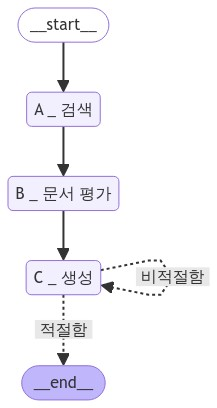

In [396]:
from IPython.display import Image, display

try:
    display(
        Image(app.get_graph(xray=True).draw_mermaid_png())
    )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. xray=True는 추가적인 세부 정보를 포함합니다.
except:
    # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
    pass

## 실행

In [397]:
# query = "사상 최고 해상도로 관측한 블랙홀의 이름은 무엇입니까?"
# query = "SK하이닉스가 최근 개발한 것은 무엇입니까?"

print(query)

# Run
inputs = {
    "question": query,
    "retriever": retriever,
    "documents": documents,
}

애플이 개발하고 있는 신기술은 무엇입니까?


In [398]:
start_time = time.time()
node_time = start_time

for output in app.stream(inputs):
    for key, value in output.items():
        current_time = time.time()
        elapsed_time = current_time - node_time
        node_time = current_time
        print(f"노드 '{key}' 완료. ({elapsed_time:.3f}s)")
    print(f"\n{'=====' * 15}\n")

end_time = time.time()
elapsed_time = end_time - start_time
print(f"{elapsed_time / 60:.3f} min")


---------------------------------------------------------------------------


>>> A _ 문서 검색 <<<

	> Retrived Documents: 3
	> Retrived Documents 0: SK하이닉스, ‘10나노급 6세대 D램’ 세계 첫 개발   속도 11%· 전력효율 9% 향상    SK하이닉스가 현존하는 D램 중 가장 미세화된 ‘10나노(㎚·1나노는 10억 분의 1m)급 6세대(1c)’ 기술을 세계 최초로 개발했다고 29일 밝혔다. 메모리 선폭을 의미하는 나노 수치가 작아질수록 처리 속도는 빨라지고, 소비전력은 줄어든다. 11∼12나노인...


	> Retrived Documents 1: ‘카툭튀’ 없는 렌즈부터 성격 가진 로봇까지… 애플이 내놓을 신기술은   아이폰16 페이스 ID 카메라에 ‘메타렌즈’ 적용설스스로 주행하며 이용자 돕는 가정용 로봇도 개발 중’시리’ 이용할 수 있는 스마트 반지 기술도 공개    아이폰 카메라에 여러 개의 굴절 렌즈가 적용돼 있는 모습./애플 제공        애플이 ‘카툭튀(카메라가 툭 튀어나온 부분)’ ...


	> Retrived Documents 2: [사이테크+] '사건의 지평선 망원경' 사상 최고 해상도로 M87* 블랙홀 관측   국제 연구팀 "ETH에 0.87㎜ 파장 첫 적용…블랙홀 관측 사상 최고 해상도" (서울=연합뉴스) 이주영 기자 = 전 세계 전파망원경들을 연결한 지구 크기 가상 망원경인 '사건의 지평선 망원경'(ETH)이 0.87㎜ 파장, 345㎓ 주파수로 M87 은하의 중앙 블랙홀(M87...


노드 'A _ 검색' 완료. (0.436s)



---------------------------------------------------------------------------

>>> B _ 문서 평가: 질문과 관련이 있는지 확인 <<<

	> 문서 0 ... 확인중
	...Flag: {'flag': '예'}
	...

In [307]:
print(f"{value['generation']}")

SK하이닉스는 '10나노급 6세대 D램' 세계 첫 개발을 통해 '11%· 전력효율 9%'의 기술을 세계 최초로 개발하였습니다.


In [134]:
print(f"{elapsed_time / 60:.3f} min")

8.035 min


# End